In [1]:
import numpy as np
from pyoculus.fields import AnalyticCylindricalBfield
from pyoculus.maps import CylindricalBfieldSection

In [2]:
import logging
logging.basicConfig(level=logging.INFO)

In [5]:
bfield = AnalyticCylindricalBfield(6, 0, 0.91, 0.6)
separatrix = {"type": "circular-current-loop", "amplitude": -10, "R": 6, "Z": -5.5}
bfield.add_perturbation(separatrix)

In [6]:
section = CylindricalBfieldSection.without_axis(bfield, finderargs={'guess': [6., 0.]}, rtol=1e-10)

INFO:pyoculus.solvers.fixed_point:Newton 0 - x : [6. 0.]
INFO:pyoculus.solvers.fixed_point:Newton 0 - delta_x : [ 0.97322329 -1.19511998]
INFO:pyoculus.solvers.fixed_point:Newton 0 - step : [ 0.83939983 -0.19155022]
INFO:pyoculus.solvers.fixed_point:Newton 1 - x : [ 6.83939983 -0.19155022]
INFO:pyoculus.solvers.fixed_point:Newton 1 - delta_x : [-0.17296755 -1.19992198]
INFO:pyoculus.solvers.fixed_point:Newton 1 - step : [-0.1222212  -0.57546205]
INFO:pyoculus.solvers.fixed_point:Newton 2 - x : [ 6.71717863 -0.76701228]
INFO:pyoculus.solvers.fixed_point:Newton 2 - delta_x : [-0.27440277 -0.30570763]
INFO:pyoculus.solvers.fixed_point:Newton 2 - step : [-0.27124768  0.03431467]
INFO:pyoculus.solvers.fixed_point:Newton 3 - x : [ 6.44593096 -0.73269761]
INFO:pyoculus.solvers.fixed_point:Newton 3 - delta_x : [-0.05285766 -0.00657196]
INFO:pyoculus.solvers.fixed_point:Newton 3 - step : [-0.03199781  0.04054267]
INFO:pyoculus.solvers.fixed_point:Newton 4 - x : [ 6.41393314 -0.69215494]
INFO:py

In [7]:
from pyoculus.solvers import PoincarePlot

In [8]:
xpoint = np.array([6.14, -4.45])
opoint = np.array([section.R0, section.Z0])
coilpoint = np.array(
    [bfield.perturbations_args[0]["R"], bfield.perturbations_args[0]["Z"]]
)

In [9]:
A = opoint + 1e-4 * (xpoint - opoint) / np.linalg.norm(xpoint - opoint)
C = coilpoint - 1e-1 * (coilpoint - xpoint) / np.linalg.norm(coilpoint - xpoint)

In [10]:
pplot = PoincarePlot.with_segments(section, [A, xpoint, C], [20, 5])

In [11]:
pplot.xs

array([[ 6.41409053, -0.69377836],
       [ 6.39966472, -0.89147424],
       [ 6.3852389 , -1.08917012],
       [ 6.37081308, -1.28686599],
       [ 6.35638726, -1.48456187],
       [ 6.34196145, -1.68225774],
       [ 6.32753563, -1.87995362],
       [ 6.31310981, -2.07764949],
       [ 6.29868399, -2.27534537],
       [ 6.28425818, -2.47304124],
       [ 6.26983236, -2.67073712],
       [ 6.25540654, -2.868433  ],
       [ 6.24098072, -3.06612887],
       [ 6.22655491, -3.26382475],
       [ 6.21212909, -3.46152062],
       [ 6.19770327, -3.6592165 ],
       [ 6.18327745, -3.85691237],
       [ 6.16885164, -4.05460825],
       [ 6.15442582, -4.25230412],
       [ 6.14      , -4.45      ],
       [ 6.10830409, -4.6877193 ],
       [ 6.07660819, -4.9254386 ],
       [ 6.04491228, -5.16315791],
       [ 6.01321637, -5.40087721]])

In [12]:
pplot.compute(nprocess=1, compute_iota=True)

array([[[ 6.41409053, -0.69377836],
        [ 6.41401618, -0.69368596],
        [ 6.41406979, -0.69358206],
        ...,
        [ 6.41416332, -0.69362226],
        [ 6.41416063, -0.69374799],
        [ 6.41405948, -0.693765  ]],

       [[ 6.39966472, -0.89147424],
        [ 6.25299266, -0.70970654],
        [ 6.3919398 , -0.49598822],
        ...,
        [ 6.54794183, -0.81484136],
        [ 6.36737749, -0.88144883],
        [ 6.25199049, -0.66262539]],

       [[ 6.3852389 , -1.08917012],
        [ 6.0896162 , -0.67459989],
        [ 6.55120469, -0.3461999 ],
        ...,
        [ 6.5125637 , -1.07998987],
        [ 6.13538688, -0.87303452],
        [ 6.3466562 , -0.30471537]],

       ...,

       [[ 6.07660819, -4.9254386 ],
        [ 6.27386084, -5.02365281],
        [ 6.26181505, -5.61547536],
        ...,
        [ 5.869826  , -5.03009287],
        [ 6.10775083, -4.92580541],
        [ 6.30009043, -5.06174446]],

       [[ 6.04491228, -5.16315791],
        [ 6.10314429, -5.17

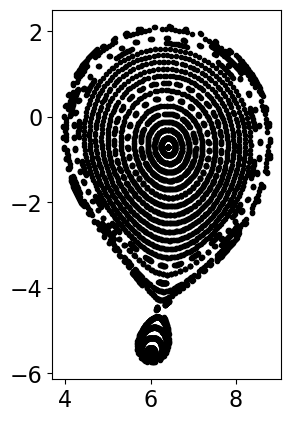

In [22]:
fig, ax = pplot.plot()

In [14]:
pplot.compute_iota()

(array([[ 6.41409053, -0.69377836],
        [ 6.39966472, -0.89147424],
        [ 6.3852389 , -1.08917012],
        [ 6.37081308, -1.28686599],
        [ 6.35638726, -1.48456187],
        [ 6.34196145, -1.68225774],
        [ 6.32753563, -1.87995362],
        [ 6.31310981, -2.07764949],
        [ 6.29868399, -2.27534537],
        [ 6.28425818, -2.47304124],
        [ 6.26983236, -2.67073712],
        [ 6.25540654, -2.868433  ],
        [ 6.24098072, -3.06612887],
        [ 6.22655491, -3.26382475],
        [ 6.21212909, -3.46152062],
        [ 6.19770327, -3.6592165 ],
        [ 6.18327745, -3.85691237],
        [ 6.16885164, -4.05460825],
        [ 6.15442582, -4.25230412],
        [ 6.14      , -4.45      ],
        [ 6.10830409, -4.6877193 ],
        [ 6.07660819, -4.9254386 ],
        [ 6.04491228, -5.16315791],
        [ 6.01321637, -5.40087721]]),
 array([ 7.92509642e-01,  7.81321255e-01,  7.50085791e-01,  7.03867606e-01,
         6.48762282e-01,  5.90330216e-01,  5.32750476e-01,

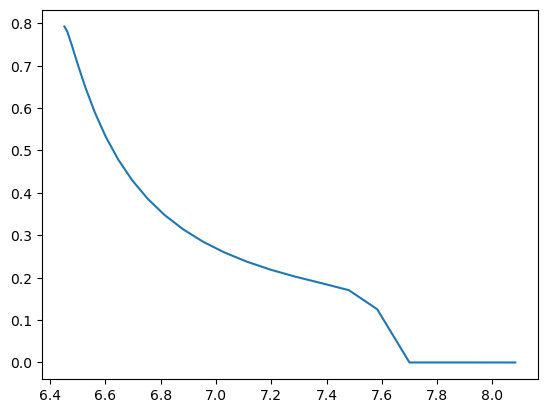

In [17]:
import matplotlib.pyplot as plt
plt.plot(np.linalg.norm(pplot.xs, axis=1), pplot.iota)

In [18]:
from pyoculus.solvers import FixedPoint

In [19]:
fp01 = FixedPoint(section)

In [20]:
guess = [6.18, -4.45]
fp01.find(1, guess)

INFO:pyoculus.solvers.fixed_point:Newton 0 - x : [ 6.18 -4.45]
INFO:pyoculus.solvers.fixed_point:Newton 0 - delta_x : [0.07626858 0.00380498]
INFO:pyoculus.solvers.fixed_point:Newton 0 - step : [ 0.02357971 -0.04555762]
INFO:pyoculus.solvers.fixed_point:Newton 1 - x : [ 6.20357971 -4.49555762]
INFO:pyoculus.solvers.fixed_point:Newton 1 - delta_x : [0.00289459 0.00225804]
INFO:pyoculus.solvers.fixed_point:Newton 1 - step : [ 4.19212955e-05 -3.39751591e-04]
INFO:pyoculus.solvers.fixed_point:Newton 2 - x : [ 6.20362163 -4.49589737]
INFO:pyoculus.solvers.fixed_point:Newton 2 - delta_x : [-6.69771223e-06 -8.35004385e-06]
INFO:pyoculus.solvers.fixed_point:Newton 2 - step : [ 1.16024945e-06 -1.30027747e-06]
INFO:pyoculus.solvers.fixed_point:Newton 3 - x : [ 6.20362279 -4.49589868]
INFO:pyoculus.solvers.fixed_point:Newton 3 - delta_x : [1.55842450e-10 1.14686038e-10]
INFO:pyoculus.solvers.fixed_point:Newton 3 - step : [ 5.16386933e-12 -2.30420127e-11]
INFO:pyoculus.solvers.fixed_point:Newton 4

In [24]:
fp01.plot(ax=ax)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

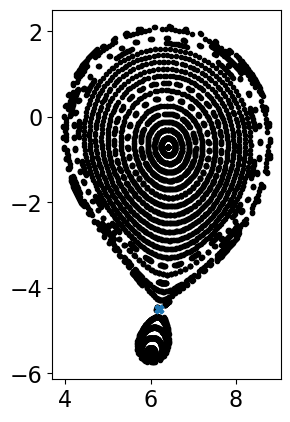

In [25]:
fig

In [ ]:
from pyoculus.solvers import Manifold